In [1]:
import os 
import pathlib
# For loading geotiff data
import rasterio
# For performing geospatial analysis
import pylandstats as pls

In [85]:
# Import modules
import numpy as np
import matplotlib.pyplot as plt
import os
from rasterio.plot import show
from rasterio.plot import show_hist
from rasterio.mask import mask
from shapely.geometry import box
import geopandas as gpd
from fiona.crs import from_epsg
import pycrs

In [3]:
CEDA_DIR = pathlib.Path("/") / "neodc"
LANDCOVER_DIR = CEDA_DIR / "esacci" / "land_cover" / "data" / "land_cover_maps" / "v2.0.7"
# Load sample data file:
landcover_2015_path = LANDCOVER_DIR / "ESACCI-LC-L4-LCCS-Map-300m-P1Y-2015-v2.0.7.tif"

In [15]:
data = rasterio.open(landcover_2015_path)

In [16]:
print(data.bounds)
print(data.shape)

BoundingBox(left=-180.0, bottom=-90.00000000001438, right=180.00000000002876, top=90.0)
(64800, 129600)


In [17]:
#Show tif
#show((data))   #full dataset too large to plot

In [70]:
# Clipping box
minx, miny = -2, 51
maxx, maxy = 1, 53
bbox = box(minx, miny, maxx, maxy)

In [71]:
# Give box a crs
geo = gpd.GeoDataFrame({'geometry': bbox}, index=[0], crs="EPSG:4326")

In [72]:
# Make sure box crs and data crs match
geo = geo.to_crs(crs=data.crs)   

In [73]:
def getFeatures(gdf):
    """Function to parse features from GeoDataFrame in such a manner that rasterio wants them"""
    import json
    return [json.loads(gdf.to_json())['features'][0]['geometry']]    #returns geojson representation of geodataframe

In [74]:
# Co-ordinates of polygon (box)
coords = getFeatures(geo)

In [75]:
# Mask(crop)
out_img, out_transform = mask(dataset=data, shapes=coords, crop=True)    #rasterio mask

In [76]:
# Meta data for new file
out_meta = data.meta.copy()
print(out_meta)

{'driver': 'GTiff', 'dtype': 'uint8', 'nodata': 0.0, 'width': 129600, 'height': 64800, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.002777777777778, 0.0, -180.0,
       0.0, -0.002777777777778, 90.0)}


In [77]:
epsg_code = int(data.crs.data['init'][5:])     #putting crs into output data

In [78]:
# Update meta-data
out_meta.update({"driver": "GTiff",
                 "height": out_img.shape[1],
                 "width": out_img.shape[2],
                 "transform": out_transform,
                 "crs": pycrs.parse.from_epsg_code(epsg_code).to_proj4()})

In [89]:
# Write output file  
out_tif = r"/gws/nopw/j04/ai4er/users/kmgreen/data/landcover_esacci_2015_cropped1.tif"
with rasterio.open(out_tif, "w+", **out_meta) as dest:
    dest.write(out_img)

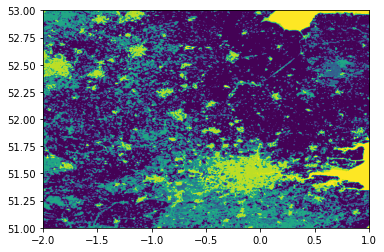

<AxesSubplot:>

In [90]:
# Quick image of new file
clipped = rasterio.open(out_tif)
show((clipped))        #shows East England

In [81]:
#Load output in pylandstats
ls=pls.Landscape(out_tif)   

<AxesSubplot:>

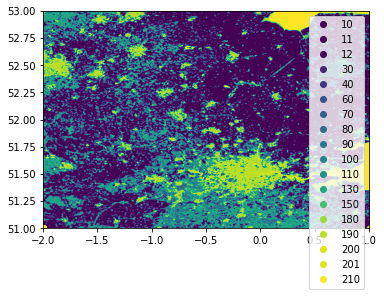

In [82]:
ls.plot_landscape(legend=True)    

In [83]:
#Calculate patch metrics using pylandstats
patch_metrics_df = ls.compute_patch_metrics_df()
patch_metrics_df.head()

,class_val,area,perimeter,perimeter_area_ratio,shape_index,fractal_dimension,euclidean_nearest_neighbor
patch_id,,,,,,,
0,10,3.858025e-09,0.033333,8.640000e+06,1.200000,0.942163,0.023733
1,10,1.543210e-09,0.022222,1.440000e+07,1.333333,0.937436,0.023733
2,10,1.543210e-09,0.016667,1.080000e+07,1.000000,0.989369,0.101986
3,10,2.314815e-09,0.022222,9.600000e+06,1.000000,0.973047,0.046564
4,10,3.086420e-09,0.027778,9.000000e+06,1.250000,0.957030,0.127808


In [84]:
#Calculate class metrics using pylandstats
class_metrics_df = ls.compute_class_metrics_df()
class_metrics_df

,total_area,proportion_of_landscape,number_of_patches,patch_density,largest_patch_index,total_edge,edge_density,landscape_shape_index,effective_mesh_size,area_mn,...,fractal_dimension_md,fractal_dimension_ra,fractal_dimension_sd,fractal_dimension_cv,euclidean_nearest_neighbor_mn,euclidean_nearest_neighbor_am,euclidean_nearest_neighbor_md,euclidean_nearest_neighbor_ra,euclidean_nearest_neighbor_sd,euclidean_nearest_neighbor_cv
class_val,,,,,,,,,,,,,,,,,,,,,
10,9.081790e-07,0.151363,429,7.150000e+07,0.002443,9.069444,15115.740741,23.666667,5.573695e-12,2.116967e-09,...,0.989369,0.174083,0.032576,3.345404,0.035146,0.032795,0.019642,0.307780,0.040141,114.214909
11,3.442438e-04,57.373971,2460,4.100000e+08,50.921039,511.855556,853092.592593,69.508982,1.556851e-04,1.399365e-07,...,0.973047,8.946088,0.169458,17.876688,0.007784,0.005648,0.006211,0.064387,0.004275,54.916676
12,2.716049e-07,0.045267,61,1.016667e+07,0.006944,1.894444,3157.407407,8.973684,6.106555e-12,4.452540e-09,...,0.973047,0.167825,0.037432,3.902929,0.056909,0.040169,0.018634,0.523959,0.101293,177.989462
30,1.542670e-05,2.571116,5664,9.440000e+08,0.006559,152.702778,254504.629630,97.363958,1.229180e-10,2.723640e-09,...,0.973047,0.309205,0.042043,4.403840,0.011835,0.010973,0.008784,0.087821,0.008152,68.882816
40,1.725849e-05,2.876415,6327,1.054500e+09,0.006173,172.230556,287050.925926,103.540000,1.289273e-10,2.727752e-09,...,0.973047,0.329945,0.042126,4.419603,0.011442,0.010779,0.008784,0.100583,0.007862,68.715235
60,8.591821e-06,1.431970,1286,2.143333e+08,0.027263,50.705556,84509.259259,43.146226,3.895404e-10,6.681043e-09,...,0.969024,0.386756,0.047454,4.986663,0.020231,0.016183,0.013889,0.143153,0.017962,88.780316
70,6.767747e-06,1.127958,668,1.113333e+08,0.199974,33.169444,55282.407407,31.829787,2.962353e-09,1.013136e-08,...,0.967801,0.815712,0.070356,7.447313,0.024962,0.014087,0.011282,0.237131,0.034147,136.792556
80,2.314815e-09,0.000386,2,3.333333e+05,0.000257,0.027778,46.296296,1.250000,4.961452e-15,1.157407e-09,...,0.994684,0.010631,0.005316,0.534398,1.609321,1.609321,1.609321,0.000000,0.000000,0.000000
90,8.333333e-08,0.013889,23,3.833333e+06,0.003858,0.711111,1185.185185,6.095238,1.444775e-12,3.623188e-09,...,0.989369,0.224216,0.053569,5.604986,0.202955,0.103865,0.128049,1.269199,0.285849,140.843588
